In [125]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import calinski_harabasz_score, confusion_matrix

from models.CAE import CAE
from models.VCAE import VCAE
from generate import sin_cos, arma, wind
from train import train
from utils import latent_space, choose_bottleneck, compute_distance_matrix

import hydra
from hydra.experimental import initialize, compose

torch.manual_seed(4444)
np.random.seed(4444)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create Dataset

In [126]:
with initialize(config_path="configs"):
    cfg = compose(config_name="config")

cfg_dataset, cfg_model, cfg_train = cfg.dataset, cfg.model, cfg.train

In [127]:
n_train, n_valid, n_test = cfg_dataset.n_train, cfg_dataset.n_valid, cfg_dataset.n_test
n = n_train+n_valid+n_test

length = cfg_model.length # each observation is a vector of size (1,length)

## Generate observations

In [128]:
#X = sin_cos(n, length)
#X = wind(num_elems=length)

X1 = arma(n//3, length, ar=[0, -0.5] , ma=[0, 0.1])
X2 = arma(n//3, length, ar=[0, 0, 0.7] , ma=[0, 0, 0.05])
X3 = arma(n//3, length, ar=[0, 0, 0, 0, -0.6] , ma=[0, 0, 0, 0, 0.2])

X = np.r_[X1,X2,X3]

c1 = np.array([0]*(n//3), dtype=np.float32).reshape(n//3, 1, 1)
c2 = np.array([1]*(n//3), dtype=np.float32).reshape(n//3, 1, 1)
c3 = np.array([2]*(n//3), dtype=np.float32).reshape(n//3, 1, 1)
Y = np.concatenate((c1,c2,c3), axis=0)
X = np.concatenate((X,Y), axis=2)

idx = list(range(len(X)))
np.random.shuffle(idx)
X = X[idx]

X = torch.from_numpy(X)
print("shape of X:", X.shape)

X_train, X_valid, X_test = X[:n_train], X[n_train:n_train+n_valid], X[n_train+n_valid:]
print("shape of X_train, X_valid, X_test:", X_train.shape, X_valid.shape, X_test.shape)

shape of X: torch.Size([1200, 1, 65])
shape of X_train, X_valid, X_test: torch.Size([1000, 1, 65]) torch.Size([100, 1, 65]) torch.Size([100, 1, 65])


In [129]:
a = scipy.stats.spearmanr(X1[:3,0,:-1], X1[:3,0,:-1], axis=1).correlation

In [130]:
a[:3,3:]

array([[ 1.        , -0.16537058,  0.02563364],
       [-0.16537058,  1.        ,  0.03533026],
       [ 0.02563364,  0.03533026,  1.        ]])

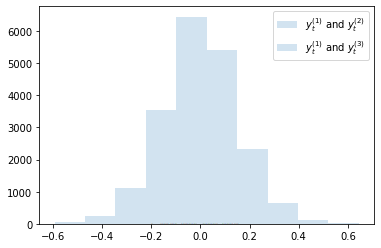

In [131]:
num = 100
cors12a = scipy.stats.spearmanr(X1[:num,0,:-1], X2[:num,0,:-1], axis=1).correlation
plt.hist(cors12a[:num,num:], label=r"$y_t^{(1)}$ and $y_t^{(2)}$", alpha=0.2)

r, c = np.triu_indices(cors12a.shape[0],1)
plt.hist(cors12a[r,c], label=r"$y_t^{(1)}$ and $y_t^{(3)}$", alpha=0.2)
plt.legend()

In [132]:
r, c = np.triu_indices(cors12a.shape[0],1)

In [133]:
cors12a[r,c]

array([-0.16537058,  0.02563364, -0.12845622, ..., -0.03206605,
        0.14314516,  0.02760177])

In [134]:
cors12a

array([[ 1.        , -0.16537058,  0.02563364, ...,  0.09773425,
         0.07771697,  0.25436828],
       [-0.16537058,  1.        ,  0.03533026, ...,  0.04233871,
        -0.03835445,  0.0515553 ],
       [ 0.02563364,  0.03533026,  1.        , ...,  0.08832565,
         0.05107527,  0.25744048],
       ...,
       [ 0.09773425,  0.04233871,  0.08832565, ...,  1.        ,
        -0.03206605,  0.14314516],
       [ 0.07771697, -0.03835445,  0.05107527, ..., -0.03206605,
         1.        ,  0.02760177],
       [ 0.25436828,  0.0515553 ,  0.25744048, ...,  0.14314516,
         0.02760177,  1.        ]])

In [135]:
cors12

array([[ 1.        , -0.16537058,  0.02563364, ..., -0.24102343,
         0.27289747,  0.30390745],
       [-0.16537058,  1.        ,  0.03533026, ..., -0.06110791,
        -0.19028418, -0.00172811],
       [ 0.02563364,  0.03533026,  1.        , ..., -0.13359255,
        -0.06499616, -0.13248848],
       ...,
       [-0.24102343, -0.06110791, -0.13359255, ...,  1.        ,
         0.0203053 , -0.04157066],
       [ 0.27289747, -0.19028418, -0.06499616, ...,  0.0203053 ,
         1.        ,  0.26195276],
       [ 0.30390745, -0.00172811, -0.13248848, ..., -0.04157066,
         0.26195276,  1.        ]])

# Data Exploration

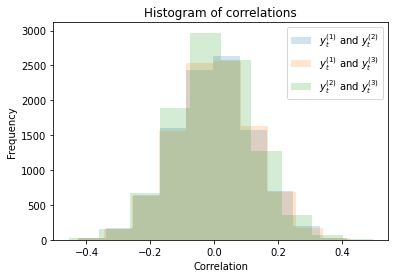

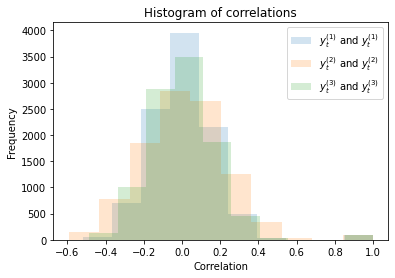

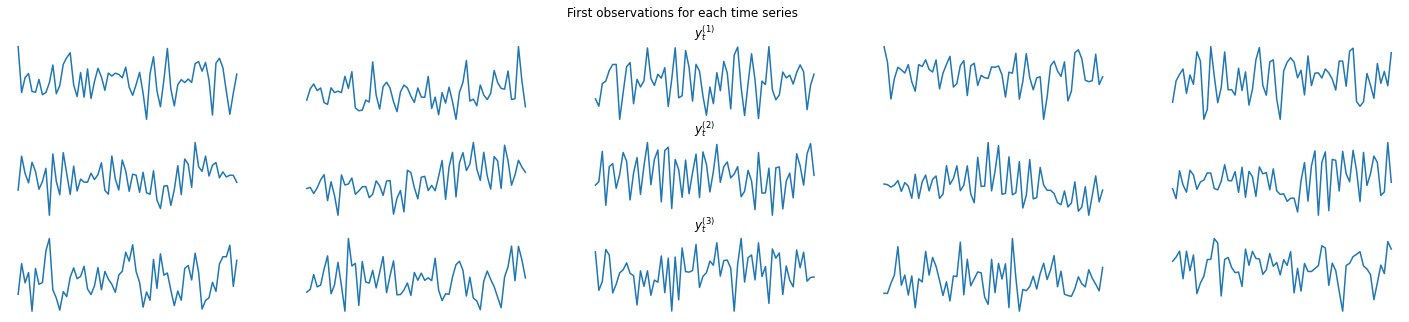

In [136]:
num = 100

def plot_hist(Xa, Xb, label, num):
    cors = scipy.stats.spearmanr(Xa[:num,0,:-1], Xb[:num,0,:-1], axis=1).correlation
    plt.hist(cors[:num,num:].flatten(), label=label, alpha=0.2)

plot_hist(X1, X2, r"$y_t^{(1)}$ and $y_t^{(2)}$", 100)
plot_hist(X1, X3, r"$y_t^{(1)}$ and $y_t^{(3)}$", 100)
plot_hist(X2, X3, r"$y_t^{(2)}$ and $y_t^{(3)}$", 100)
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.title("Histogram of correlations")
plt.legend()
plt.show()

plot_hist(X1, X1, r"$y_t^{(1)}$ and $y_t^{(1)}$", 100)
plot_hist(X2, X2, r"$y_t^{(2)}$ and $y_t^{(2)}$", 100)
plot_hist(X3, X3, r"$y_t^{(3)}$ and $y_t^{(3)}$", 100)
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.title("Histogram of correlations")
plt.legend()
plt.show()

n_plots = 5
fig, axs = plt.subplots(nrows=3, ncols=n_plots, figsize=(25,5))
for i in range(3):
    for j in range(n_plots):
        axs[i,j].axis("off")
        if i == 0:
            axs[0,j].plot(X1[j,0])
        elif i == 1:
            axs[1,j].plot(X2[j,0])
        else:
            axs[2,j].plot(X3[j,0])

axs[0,n_plots//2].set_title(r"$y_t^{(1)}$")
axs[1,n_plots//2].set_title(r"$y_t^{(2)}$")
axs[2,n_plots//2].set_title(r"$y_t^{(3)}$")
_ = plt.suptitle("First observations for each time series")

# Compare to baseline

In [137]:
from sklearn.neighbors import KNeighborsClassifier

best_acc = 0
best_k = 0
for i in range(1,50):

    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train[:,0,:-1], X_train[:,0,-1])

    ypred = neigh.predict(X_valid[:,0,:-1])
    ypred.astype(int)
    yreal = X_valid[:,0,-1].numpy()
    yreal.astype(int)

    acc = np.sum(ypred == yreal)/len(yreal)
    if best_acc < acc:
        best_acc = acc
        best_k = i
print("Best k:", best_k)
print("Accuracy:", best_acc)

Best k: 10
Accuracy: 0.79


Accuracy: 0.87


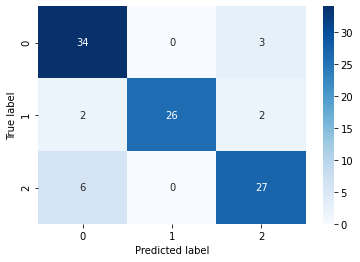

In [138]:
neigh = KNeighborsClassifier(n_neighbors=best_k)
X_aux = np.r_[X_train, X_valid]
neigh.fit(X_aux[:,0,:-1], X_aux[:,0,-1])

ypred = neigh.predict(X_test[:,0,:-1])
ypred.astype(int)
yreal = X_test[:,0,-1].numpy()
yreal.astype(int)

cm = confusion_matrix(yreal, ypred)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
print("Accuracy:", np.sum(np.diag(cm))/np.sum(cm))

# Model

In [139]:
model = CAE(cfg_model)

In [140]:
train_losses, valid_losses = train(model, cfg_train, X_train, X_valid)

EPOCH 10 train loss: 1.0372751355171204, valid loss: 1.1366832852363586
epochs without improvement: 1

EPOCH 20 train loss: 0.8651341088116169, valid loss: 1.0211302936077118
epochs without improvement: 0

EPOCH 30 train loss: 0.8026410732418299, valid loss: 0.980184480547905
epochs without improvement: 1

EPOCH 40 train loss: 0.7613951414823532, valid loss: 1.008650779724121
epochs without improvement: 6

EPOCH 50 train loss: 0.7392462007701397, valid loss: 0.9776242822408676
epochs without improvement: 16

EPOCH 60 train loss: 0.7240572329610586, valid loss: 0.9715538620948792
epochs without improvement: 26

EPOCH 70 train loss: 0.7223467417061329, valid loss: 0.9791230857372284
epochs without improvement: 1

EPOCH 80 train loss: 0.7423963695764542, valid loss: 1.0358281433582306
epochs without improvement: 11

EPOCH 90 train loss: 0.6967835910618305, valid loss: 0.9686151444911957
epochs without improvement: 1

EPOCH 100 train loss: 0.6815776098519564, valid loss: 1.0204667150974274

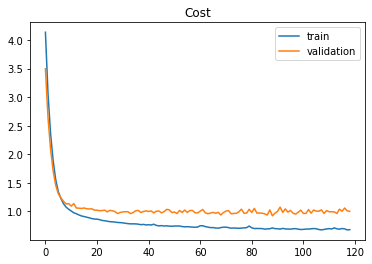

In [141]:
plt.title("Cost")
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="validation")
plt.legend()

## Load/Save model

In [142]:
#torch.save(model.state_dict(), "../saved_weights/vcae_kl0.25")
#model.load_state_dict(torch.load("../saved_weights/vcae_kl0.25"))

# Testing

## Average and std correlation

avg and std: 0.6110650183150182 0.09993804565134107

cor: 0.5949633699633698
cor: 0.6978937728937727
cor: 0.5209249084249082
cor: 0.5906135531135531


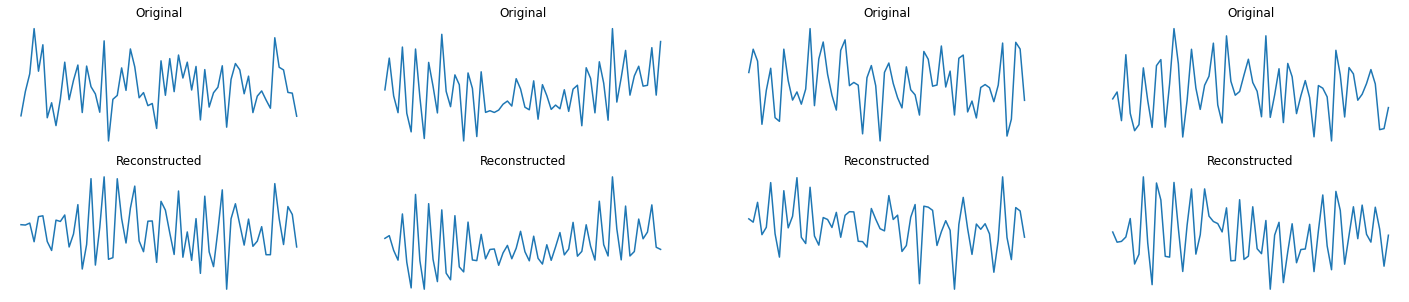

In [143]:
pred = model(X_test).detach().numpy()
inp = X_test[:,:,:-1]

# avg and std of cors
cors = [scipy.stats.spearmanr(pred[i,0], inp[i,0]).correlation for i in range(n_test)]
print("avg and std:", np.mean(cors), np.std(cors))
print()

# plots
n_plots = 4
start = n_plots*0

fig, axs = plt.subplots(nrows=2, ncols=n_plots, figsize=(25,5))
for i in range(n_plots):
    
    axs[0,i].axis("off")
    axs[0,i].set_title("Original")
    axs[0,i].plot(inp[start+i,0])

    axs[1,i].axis("off")
    axs[1,i].set_title("Reconstructed")
    axs[1,i].plot(pred[start+i,0])
    print("cor:", scipy.stats.spearmanr(pred[start+i,0], inp[start+i,0]).correlation)

Accuracy: 0.86


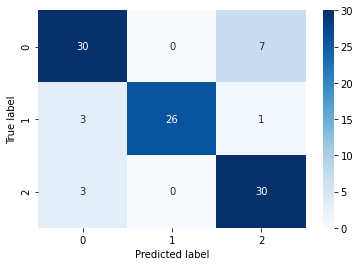

In [144]:
inp = X_test # data to perfom prediction
_, output = model(inp, get_training=True)
probs = torch.nn.functional.softmax(output, dim=1)
pred = torch.argmax(probs, dim=1).detach().numpy()
real = inp[:,:,-1].flatten().long().detach().numpy()

cm = confusion_matrix(real, pred)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")

print("Accuracy:", np.sum(np.diag(cm))/np.sum(cm))

# Checking important filters

<AxesSubplot:>

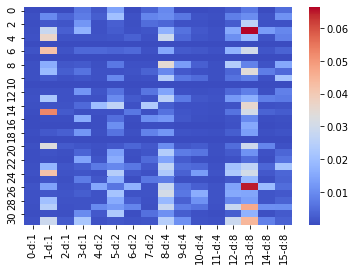

In [145]:
num_filter = len(model.dilation)*cfg_model.M
w_per_filter = cfg_model.length-cfg_model.Lf+1 # weights per filter
num_neurons = cfg_model.bottleneck_nn
M = cfg_model.M 

if isinstance(model, VCAE):
    num_neurons *= 2

w = np.array([[torch.mean(torch.abs(model.full1.weight[j,i*w_per_filter:(i+1)*w_per_filter])).item() for i in range(num_filter)] for j in range(num_neurons)])

x_axis_labels = [f"{i}-d:{model.dilation[i//M]}" for i in range(w.shape[1])] # number of filter - d:dilatation
sns.heatmap(w, cmap="coolwarm", xticklabels=x_axis_labels) # y-axis => neuron of the bottleneck, x-axis => each position is one filter ordered by dilatation